# Gram continuation algorithm

This notebook implements the Gram-Fourier continuation algorithm (first developed by Lyon and Bruno (https://doi.org/10.1016/j.jcp.2009.11.020, https://doi.org/10.1016/j.jcp.2010.01.006) to compute extension and interpolation tables.

It notebook uses the arbitrary floating point precision library mpmath and implements the Gram-Schmidt orthogonalisation algorithm and computes the left and right orthogonal polynomial basis. It then uses the mpmath's SVD algorithm to compute accurate continuations of the Gram polynomials. Finally, it computes matrices that compute the forward and backward FFTs in high precision. The results of all these computations are stored in binary files in double precision. 
Furthermore, the notebook can create header files with the extension and interpolation tables. 
Executing the first cell executes steps 1-4 (takes around 12 hours on a 16-Core CPU for all extensions provided in GAMER).

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from mpmath import *

mp.dps = 64
eps = 1e-64

# Implement the Gram Schmidt orthogonalisation algorithm using mpmath 
class GramSchmidt:
    def __init__(self, x, m):
        self.x = x 
        self.m = m 
        self.A = mp.zeros(m, len(x))
        #Linear map for polynomial scalar product
        for i in range(m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                self.A[i, j] = x[j]**i

        #Write basis vector as columns of matrix V
        self.V = mp.eye(m)

        self.U = self.modifiedGramSchmidt(self.V) 

    def evaluateBasis(self, x, basis_element): 
        #Linear map for polynomial scalar product
        A = mp.zeros(self.m, len(x))
        for i in range(self.m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                A[i, j] = x[j]**i
        ei = self.U[:, basis_element].T * A 
        
        return ei
    
    def sp(self, u, v):
        return mp.fsum((u.T * self.A) * (v.T * self.A).T)

    def proj(self, u, v):
        a1 = self.sp(v, u) 
        a2 = self.sp(u, u)
        return a1/a2 * u 

    def norm(self, u):
        return mp.sqrt(self.sp(u, u))

    def modifiedGramSchmidt(self, V): 
        n, k = V.rows, V.cols
        U    = V.copy()
        U[:, 0] = V[:, 0] / self.norm(V[:, 0]) 

        for i in range(1, k): 
            for j in range(i, k): 
                U[:, j] = U[:, j] - self.proj(U[:, i - 1], U[:, j])


            U[:, i] = U[:, i] / self.norm(U[:, i])
        return U

    def projectFunction(self, f): 
        coeffs = mp.matrix(1, self.m) 

        for i in range(self.m): 
            basis = (self.U[:, i].T * self.A)
            coeffs[0, i] = mp.fsum(f * basis.T)


        return coeffs
    
    def reconstructFunction(self, coeffs, x = None): 
        if x == None:
            A = self.A
        else: 
            A = mp.zeros(self.m, len(x))
            for i in range(self.m): 
                for j in range(len(x)): 
                    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                    self.A[i] = x[j]**i
            
        frec = mp.matrix(1, A.cols)
        for i in range(self.m): 
            frec += coeffs[0, i] * (self.U[:, i].T * A)
        return frec 
    
    def debugInformation(self):
        m = self.m 
        u_ij = mp.zeros(m) 

        plt.title(f"Unorthogonalised polynomials m = {m}")
        for i in range(m):
            plt.plot(x, self.V[:, i].T * self.A, label=f"x^{i}")
        plt.legend()
        plt.show()



        plt.title(f"Orthonormalised polynomials m = {m}")
        for i in range(m):
            plt.plot(self.x, self.U[:, i].T * self.A, label=f"{i}")
        plt.legend()
        plt.show()

        print("The orthonormalised polynomials and their scalar products")
        for i in range(m):
            for j in range(m):
                u_ij[i, j] = self.sp(self.U[:, i], self.U[:, j])
            print(f"i = {i} u_ij = {u_ij[i, :]}")

class SVDFourierExtension:
    # Implement the SVD Fourier continuation algorithm using mpmath 
    M_ALL_K  = 0 
    M_EVEN_K = 1
    M_ODD_K  = 2 

    def __init__(self, m, nDelta, nd, Gamma, g): 
        # Set up evaluation grid 
        h      = 1/(nd - 1) 
        d      = (nd - 1) * h 
        Delta  = (nDelta  - 1) * h 

        x = mp.linspace(0, 1, nd)

        # Compute left and right Gram Schmidt extensions 
        leftBoundary  = x[       :nDelta]
        rightBoundary = x[-nDelta:      ]

        lgs = GramSchmidt(leftBoundary, m)
        rgs = GramSchmidt(rightBoundary, m)

        dxeval = Delta/(Gamma - 1) 
        xeval  = mp.matrix(1, Gamma) 
        for i in range(Gamma): 
            xeval[0, i] = 1 - Delta + i * dxeval

        #Set up extension grid 
        xext  = mp.linspace(1 - Delta, 1 + Delta + 2*d, 1000) 
        mode  = self.M_EVEN_K
        M     = self.getM(g, Gamma, Delta, d, mode)
        Minv  = self.invertComplexM(M, 0)
        evencoeffs = []
        evenbasis  = []
        evenfrecs  = []
        for i in range(m): 
            yeval = rgs.evaluateBasis(xeval, i)
            a     = self.iterativeRefinement(M, Minv, yeval) 
            frec  = self.reconstruct(xext, a, g, Gamma, Delta, d, mode)
            evencoeffs.append(a) 
            evenbasis.append(yeval)
            evenfrecs.append(frec)


        mode  = self.M_ODD_K
        M     = self.getM(g, Gamma, Delta, d, mode)
        Minv  = self.invertComplexM(M, 0)
        oddcoeffs = []
        oddbasis = []
        oddfrecs = []
        for i in range(m): 
            yeval = rgs.evaluateBasis(xeval, i)
            a     = self.iterativeRefinement(M, Minv, yeval) 
            frec  = self.reconstruct(xext, a, g, Gamma, Delta, d, mode)
            oddcoeffs.append(a) 
            oddbasis.append(yeval)
            oddfrecs.append(frec)

        Next = 2 * nd + 2 * nDelta - 4
        xstore = mp.matrix(1, Next)
        for i in range(Next): 
            xstore[i] = 1 - Delta + i * h

        self.F = mp.matrix(2 * m, Next)

        mode = self.M_EVEN_K

        for i in range(m): 
            self.F[i, :] = self.reconstruct(xstore, evencoeffs[i], g, Gamma, Delta, d, mode)

        mode = self.M_ODD_K
        for i in range(m): 
            self.F[i+m, :] = self.reconstruct(xstore, oddcoeffs[i], g, Gamma, Delta, d, mode)

        self.Pr = mp.matrix(m, nDelta)
        self.Pl = mp.matrix(m, nDelta)
        for i in range(m): 
            self.Pr[i, :] = rgs.evaluateBasis(rightBoundary, i)
            self.Pl[i, :] = lgs.evaluateBasis(leftBoundary, i)


        self.numpyF = np.array(self.F.apply(mp.re), dtype=np.float128).reshape(2 * m, Next)
        self.numpyF.tofile(f"extension_tables/F_nD={nDelta}_nd={nd}_g={g}_Gamma={Gamma}.bin")
        self.numpyPr = np.array(self.Pr, dtype=np.float128).reshape(m, nDelta) 
        self.numpyPr.tofile(f"polynomials/Pright_m={m}_nD={nDelta}.bin")
        self.numpyPl = np.array(self.Pl, dtype=np.float128).reshape(m, nDelta) 
        self.numpyPl.tofile(f"polynomials/Pleft_m={m}_nD={nDelta}.bin")       

    # Pick Fourier modes
    def t(self, g, mode = M_ALL_K):
        if g % 2 == 0:
            k = np.arange(-int(-g/2) + 1, int(g/2) + 1)
        else:
            k = np.arange(-int((g-1)/2), int((g-1)/2) + 1)

        if mode == self.M_EVEN_K:
            k = k[k % 2 == 0]
        elif mode == self.M_ODD_K:
            k = k[k % 2 == 1]

        return k * mp.mpf(1)
        
    # Return array for evaluation of Gram polynomials 
    def getX(self, Delta, Gamma):
        dxeval = Delta/(Gamma - 1) 
        xeval  = mp.matrix(1, Gamma) 
        for i in range(Gamma): 
            xeval[0, i] = 1 - Delta + i * dxeval
        return xeval

    # Return array with values of plane waves at evaluation points 
    def getM(self, g, Gamma, Delta, d, mode): 
        ks = self.t(g, mode)
        x  = self.getX(Delta, Gamma) 
        M  = mp.matrix(Gamma, len(ks))
        for i in range(Gamma):
            for j, k in enumerate(ks):
                M[i, j] = mp.exp(1j * k * np.pi / (d + Delta) * x[0, i])
        return M

    # Invert plane wave array using SVD with truncation of singular values below threshold
    def invertComplexM(self, M, cutoff):
        U, s, Vh = mp.svd(M)
        sinv = mp.diag(s) 
        r = M.cols
        if M.rows < M.cols:
            r = M.rows
        for i in range(r):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]

        Vht = Vh.transpose_conj()
        Ut  = U.transpose_conj()
        f1  = sinv * Ut
        f2  = Vht * f1 
        return  f2

    # Evaluate Fourier extension at point x 
    def reconstruct(self, x, a, g, Gamma, Delta, d, mode): 
        ks = self.t(g, mode)
        rec = mp.matrix(1, len(x)) 
        for j, coeff in enumerate(a): 
            for i in range(len(x)): 
                rec[i] += coeff * mp.exp(1j * ks[j] * np.pi / (d + Delta) * x[i])
        return rec

    # Iterative refinement for SVD-based matrix inversion
    def iterativeRefinement(self, M, Minv, f, threshold = 100, maxiter = 1000):
        a       = Minv * f.T
        r       = M * a - f.T
        counter = 0
        while mp.norm(r) > 2 * eps * mp.norm(a) and counter < maxiter: 
            delta    = Minv * r
            a        = a - delta 
            r        = M * a - f.T
            counter += 1
        return a

    def computeExtension(self, x, g, Gamma, Delta, d, mode, f, threshold = 10, maxiter = 10):
        M     = self.getM(g, Gamma, Delta, d, mode)
        Minv  = self.invertComplexM(M, 0) 
        a     = self.iterativeRefinement(M, Minv, f) 
        frec  = self.reconstruct(x, a, g, Gamma, Delta, d, mode)
        return frec

class GramFEFixedSizeExtension: 

    def __init__(self, N, m, nDelta, nd, Gamma, g): 
        self.N      = N 
        self.m      = m 
        self.nDelta = nDelta
        self.nd     = nd 
        self.Gamma  = Gamma 
        self.g      = g 

        # compute accurate Gram-Fourier extension
        extension = SVDFourierExtension(m, nDelta, nd, Gamma, g)
        self.extension = extension 

        # size of extension 
        nExt = nd - 2

        # matrix with left and right Gram polynomials 
        # Pb  = np.block([[Pl, np.zeros((nDelta, nDelta))], [np.zeros((nDelta, nDelta)), Pr]])
        Pb = mp.zeros(2*nDelta) 
        for i in range(nDelta):
            for j in range(nDelta): 
                Pb[i,          j         ] = extension.Pl[i, j]
                Pb[i + nDelta, j + nDelta] = extension.Pr[i, j]

        # matrix that combines left and right Gram polynomials to get even and odd extensions
        # mix = np.block([[np.identity(nDelta) * 0.5, np.identity(nDelta) * 0.5], [np.identity(nDelta) * (-0.5), np.identity(nDelta) * 0.5]])
        Shuffle = mp.zeros(2*nDelta) 
        for i in range(nDelta):
            Shuffle[i         , i         ] = +0.5
            Shuffle[i         , i + nDelta] = +0.5
            Shuffle[i + nDelta, i         ] = -0.5 
            Shuffle[i + nDelta, i + nDelta] = +0.5 

        # matrix that combines left and right extensions 
        # Fb = np.transpose(np.concatenate([Fe, Fo], axis=0))
        # Fe   = F[:nDelta, nDelta:nDelta + nd - 2]
        # Fo   = F[nDelta:, nDelta:nDelta + nd - 2]

        Fb = mp.matrix(nExt, 2 * nDelta)
        for i in range(nExt):
            for j in range(nDelta): 
                Fb[i, j         ] = extension.F[j         , nDelta + i]
                Fb[i, j + nDelta] = extension.F[j + nDelta, nDelta + i]

        # matrix that maps the input function to the extended domain 
        #extendWavefunction = np.block([[np.identity(N)],
        #                              [np.identity(nDelta), np.zeros((nDelta, N - nDelta))],
        #                              [np.zeros((nDelta, N - nDelta)), np.identity(nDelta)]]
        #                              )
        extendWavefunction = mp.zeros(N + 2 * nDelta, N)
        for i in range(N):
            extendWavefunction[i,i] = 1

        for i in range(nDelta):
            extendWavefunction[N          + i,              i] = 1
            extendWavefunction[N + nDelta + i, N - nDelta + i] = 1

        # matrix that maps the input function to the extended wave function 
        #computeExtension = np.block([[np.identity(N), np.zeros((N, 2*nDelta))],
        #                            [np.zeros((nd - 2, N)), transform]])

        transform      = Fb * Shuffle * Pb 
        self.nExtended = N + nExt

        computeExtension = mp.zeros( N + nExt, N + 2*nDelta )
        for i in range(N):
            computeExtension[i, i] = 1
        for i in range(nExt):
            for j in range(2 * nDelta):
                computeExtension[N + i, N +j] = transform[i, j]

        self.computeExtension = computeExtension @ extendWavefunction

        numpyComputeExtension = np.array(self.computeExtension.tolist(), dtype=np.complex128).reshape(self.nExtended, self.N).astype(np.float128)
        numpyComputeExtension.tofile(f"extension_tables/N={self.N}_nD={nDelta}_nd={nd}_g={g}_Gamma={Gamma}.bin")

        # matrix that computes FFT 
        self.computeFFT  = self.dftmat(self.nExtended)
        numpyFFTMatrix = np.array(self.computeFFT.tolist(), dtype=np.complex128).reshape(self.nExtended, self.nExtended).astype(np.float128)
        numpyFFTMatrix.tofile(f"fft_tables/N={self.nExtended}.bin")

        # matrix that extends and computes FFT 
        self.computeExtendedFFT = self.computeFFT * self.computeExtension
        numpyComputeExtensionFFT = np.array(self.computeExtendedFFT.tolist(), dtype=np.complex128).reshape(self.nExtended, self.N).astype(np.float128)
        numpyComputeExtensionFFT.tofile(f"extension_tables/FFT_N={self.N}_nD={nDelta}_nd={nd}_g={g}_Gamma={Gamma}.bin")

        # matrix that computes inverse FFT 
        self.computeIFFT  = self.idftmat(self.nExtended)
        numpyIFFTMatrix = np.array(self.computeIFFT.tolist(), dtype=np.complex128).reshape(self.nExtended, self.nExtended).astype(np.float128)
        numpyIFFTMatrix.tofile(f"ifft_tables/N={self.nExtended}.bin")

    def dftmat(self, N):
        M = mp.matrix(N, N)
        for i in range(N):
            for j in range(N): 
                M[i, j] = mp.exp(-2j * mp.pi * i * j / N)
        
        return M
    
    def idftmat(self, N):
        M = mp.matrix(N, N)
        for i in range(N):
            for j in range(N): 
                M[i, j] = mp.exp(2j * mp.pi * i * j / N) / N

        return M

class GramFEInterpolation: 

    def __init__(self, N, m, nDelta, nd, Gamma, g): 
        self.N      = N 
        self.m      = m 
        self.nDelta = nDelta
        self.nd     = nd 
        self.Gamma  = Gamma 
        self.g      = g 

        # compute accurate Gram-Fourier extension
        self.extension = GramFEFixedSizeExtension(N, m, nDelta, nd, Gamma, g)

        # matrix that evaluates extended input function in k-space at the interpolation points xx 
        xend = 1 * ((N - 1) / (self.extension.nExtended))
        dx   = xend / (N - 1)
        xx   = mp.linspace(0.75 * dx, xend - 0.75 * dx , 2 * (N - 2))
        computeInterpolation = self.computeInterpolationMatrix(self.extension.nExtended, xx)


        # matrix that maps the input function of size N to the 2 * (N - 2) interpolated values (requires a ghost boundary of at least one)
        self.interpolationMatrix = computeInterpolation @ self.extension.computeFFT @ self.extension.computeExtension
        self.numpyInterpolationMatrix = np.array(self.interpolationMatrix.tolist(), dtype=complex).reshape(2 * (N - 2), N).astype(float)
        self.numpyInterpolationMatrix.tofile(f"interpolation_tables/N={N}_m={m}_nDelta={nDelta}_nd={nd}_Gamma={Gamma}_g={g}.bin")



    def computeInterpolationMatrix(self, N, xarray): 
        N1 = len(xarray)
        M = mp.matrix(N1, N)
        for i in range(N1): 
            for j in range(N):
                if j < N/2 + 1:
                    kn = j 
                else: 
                    kn = j - N 
                M[i, j] = mp.exp(2j * mp.pi * xarray[i] * kn) / N
        return M 
    
    def test(self, func = lambda x: np.sin(10 * x)):

        # Generate the x values at which to sample the function
        x = np.linspace(0, 1, self.N)
        dx = x[1]-x[0]

        # Evaluate the function at the sample points
        y = func(x)

        dx = 1/(self.N - 1) 
        xx = np.linspace(0.75 * dx, 1 - 0.75*dx, 2 * (self.N - 2))
        
        # Compute the FFT of the function
        interp = self.numpyInterpolationMatrix @ y 


        # Print the interpolated value
        plt.title("Gram interpolation routine")
        plt.plot(x,func(x),'-', label="Original")
        plt.plot(xx, interp, label="Interpolated")
        plt.legend()
        plt.show()

        plt.title("Interpolation error")
        plt.yscale("log")
        plt.plot(xx, np.abs(interp-func(xx)),'.')
        plt.show()


## Compute SVD extensions for a range of useful sizes
Executing this cell might take a long time > 100h. 
Try with smaller loop range first to estimate speed on your hardware. 

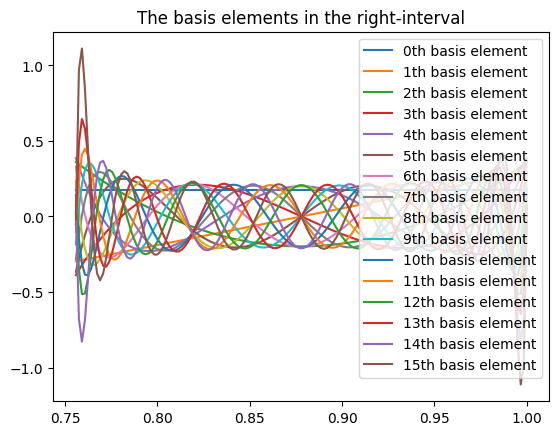

In [47]:

#### DEFAULT PARAMS
# m      = 10
# n      = 10 
# nDelta = 10 
# nd     = 27
# Gamma  = 150
# g      = 63
####################

Gamma  = 150
g      = 63
for nd in range(18, 39): 
    for m in range(6, 15): 
        print(f"SVD: nd = {nd} m = {m}")
        svdext = SVDFourierExtension(m, m, nd, Gamma, g) 


## Compute SVD interpolation objects

In [ ]:
Gamma  = 150
g      = 63
nd     = 32
m      = 14 
# Let polynomial order be size of interpolation domain up to N = 14
for N in range(2, 14): 
    print(f"SVD: N = {N}")
    svdext = GramFEInterpolation(N, N, N, nd, Gamma, g)
    
# Keep polynomial order fixed for larger domain sizes for stability 
for N in range(15, 33): 
    print(f"SVD: N = {N}")
    svdext = GramFEFixedSizeExtension(N, m, m, nd, Gamma, g) 

## Create header files for GAMER

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy

def printCMatrix(mat, name):
    n, m = mat.shape    

    print(f"GPU_DEVICE_VARIABLE const static gramfe_float  {name}[{n}][{m}] = ", end="")
    print("{")
    for i in range(n):
        print("{", end="")
        for j in range(m):
            print(f"{mat[i,j]:10.64f}", end="")
            if j != m - 1:
                print(", ", end="")
        

        print("}", end=",\n")  
    print("}", end=";\n")  

print(
r"""
# ifndef __GRAM_EXTENSION_TABLES_H__
# define __GRAM_EXTENSION_TABLES_H__

# if ( WAVE_SCHEME == WAVE_GRAMFE )
# include "CUFLU.h"
# include "Macro.h"


// **********************************************************************************************************
// ** Precomputed (at least) double precision values of Gram polynomials and their periodic Fourier        **
// ** extensions as used in the Gram-Fourier extension algorithm.                                          **
// ** GRAMFE_NDELTA = 6, 8, 10, 12, 14                                                                     **
// ** GRAMFE_ND     = 24, 26, 28, 30, 32, 34, 36                                                           **
// **********************************************************************************************************""")


first = 1
for nD in [6, 8, 10, 12, 14]:
    for nd in [26, 28, 30, 32, 34, 36, 38]:
        g     = 63 
        Gamma = 150 


        F = np.fromfile(f"nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        Fe = F[:nD, nD:nD + nd - 2]
        Fo = F[nD:, nD:nD + nd - 2]


        if first: 
            print(f"\n# if (GRAMFE_NDELTA == {nD} && GRAMFE_ND == {nd - 2})\n")
            first = 0
        else:
            print(f"\n# elif (GRAMFE_NDELTA == {nD} && GRAMFE_ND == {nd - 2})\n")


        printCMatrix(Fe, "Fe")
        print("")
        printCMatrix(Fo, "Fo")
        print("")

print(
r"""# else
# error: ERROR : Unsupported Gram Fourier Extension
# endif""")

first = 1

for nD in [6, 8, 10, 12, 14]:
    Pl = np.fromfile(f"Pleft_nD={nD}.bin").reshape(nD, nD) 
    Pr = np.fromfile(f"Pright_nD={nD}.bin").reshape(nD, nD) 

    if first: 
        print(f"\n# if (GRAMFE_NDELTA == {nD})\n")
        first = 0
    else:
        print(f"\n# elif (GRAMFE_NDELTA == {nD})\n")

    printCMatrix(Pl, "Pl")
    print("")
    printCMatrix(Pr, "Pr")
print(
r"""# else
# error: ERROR : Unsupported Gram Polynomial
# endif

# endif // # if ( WAVE_SCHEME == WAVE_GRAMFE )
# endif // # ifndef __GRAM_EXTENSION_TABLES_H__""")